In [1]:
import numpy as np
from sklearn.metrics import euclidean_distances
import pandas as pd

import sys
sys.path.insert(0, '../SOM-LVQ')
from minisom import MiniSom
import LVQ
from pylab import bone, pcolor, colorbar, plot, show

In [2]:
data = pd.read_csv(r"../data/rocktype.csv")
x = data.iloc[:, 0:6].values
y = data.iloc[:, 6].values
y[y==4] = 0
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=44)

# use Minmaxscaler because we use euclidean distance
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_test = minmax.transform(x_test)

C:\Users\Thend\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Training the SOM
som = MiniSom(x = 15, y = 15, input_len = 6, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(x_train)
som.train_random(data = x_train, num_iteration = 100)

In [4]:
# Visualizing the results
def visualSom(x_train, y_train, som):
    numLabels = len(np.unique(y_train))
    labels = np.zeros((numLabels, som.x, som.y))
    bone()
    pcolor(som.distance_map().T)
    colorbar()
    markers = ['v', 's', 'o', '4']
    colors = ['r', 'g', 'b', 'y']
    for i, x in enumerate(x_train):
        w = som.winner(x)
        plot(w[0] + 0.5,
             w[1] + 0.5,
             markers[y_train[i]],
             markeredgecolor = colors[y_train[i]],
             markerfacecolor = 'None',
             markersize = 10,
             markeredgewidth = 2)
        for nl in range(numLabels):
            if y_train[i] == nl:
                labels[nl, w[0], w[1]] += 1
    show()
    return labels

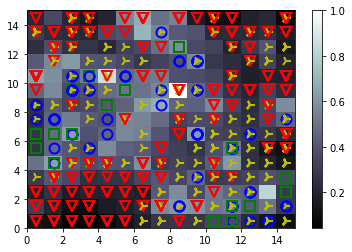

In [5]:
labels = visualSom(x_train=x_train, y_train=y_train, som=som)

In [6]:
def propabilitySom(labels):
    propa = np.zeros((labels.shape[0], labels.shape[1], labels.shape[2]))
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            for k in range(labels.shape[2]):
#                 total = labels[0, j, k] + labels[1, j, k] + labels[2, j, k] + labels[3, j, k]
                total = sum(labels[i, j, k] for i in range(labels.shape[0]))
                if total == 0. :
                    continue
                else:
                    propa[i, j, k] = labels[i, j, k] / total
                    propa[i, j, k] = round(propa[i, j, k], 2)
    return propa

In [7]:
propa = propabilitySom(labels)

In [8]:
p_vectors = som.weights

In [9]:
def taggingSom(labels):
    x = labels.shape[1]
    y = labels.shape[2]
    tag = labels.shape[0]
    taggings = np.zeros((x, y))
    for i in range(x):
        for j in range(y):
            tmp = np.array([labels[t][i][j] for t in range(tag)])
            sort = tmp.argsort()
            if (tmp[sort[tag-1]] <= tmp[sort[tag-2]] * 5): # must be improve
                taggings[i][j] = np.random.choice([sort[tag-1], sort[tag-2]])
            else:
                taggings[i][j] = sort[tag-1]
    return taggings

In [10]:
taggings = taggingSom(labels=labels)

In [11]:
def find_closest(in_vector, proto_vectors, labels):
    """
    Find the closest prototype vector for a given vector

    Parameters
    -------
    in_vector: the given vector
    proto_vectors: the set of prototype vectors
    """
    closest_distance = 99999
    x = labels.shape[1]
    y = labels.shape[2]
    for i in range(x):
        for j in range(y):
            if (sum(labels[k, i, j] for k in range(labels.shape[0])) == 0):
                continue
            else:
                distance = np.linalg.norm(in_vector - proto_vectors[i][j])
                if distance < closest_distance:
                    closest_distance = distance
                    closest = (i, j)         
    return closest

In [12]:
def predict(test_vector, p, taggings, labels):
    position = find_closest(test_vector, p, labels)
    return taggings[position[0], position[1]]

In [13]:
predicted_y1 = [predict(instance, p_vectors, taggings, labels) for instance in x_test]

from sklearn.metrics import classification_report

print (classification_report(y_test, predicted_y1, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.89      0.89      0.89       229
          1       0.83      0.84      0.83        63
          2       0.44      0.55      0.49        33
          3       0.76      0.73      0.75       168

avg / total       0.81      0.81      0.81       493



In [14]:
data_new = pd.read_csv(r"../data/SD-3X_rocktype.csv")
x_new = data_new.iloc[:, 0:6].values
y_new = data_new.iloc[:, 6].values
y_new[y_new == 4] = 0
x_new = minmax.fit_transform(x_new)
predicted_y_new = [predict(instance, p_vectors, taggings, labels) for instance in x_new]

from sklearn.metrics import classification_report

print (classification_report(y_new, predicted_y_new, target_names=['0', '1', '2', '3']))

             precision    recall  f1-score   support

          0       0.93      0.62      0.75       331
          1       0.96      0.94      0.95        95
          2       0.44      0.62      0.52        26
          3       0.57      0.85      0.68       205

avg / total       0.80      0.74      0.75       657



# Next SOM

In [15]:
# Training the SOM
from minisom import MiniSom
som2 = MiniSom(x = 15, y = 15, input_len = 6, sigma = 1.0, learning_rate = 0.5)
som2.random_weights_init(x_train)
som2.train_random(data = x_train, num_iteration = 100)

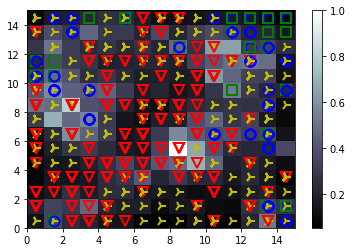

In [16]:
# Visualizing the results
labels2 = visualSom(x_train, y_train, som=som2)

In [17]:
propa2 = propabilitySom(labels2)

In [18]:
p_vectors2 = som2.weights

In [19]:
taggings2 = taggingSom(labels2)

In [20]:
predicted_y2 = [predict(instance, p_vectors2, taggings2, labels2) for instance in x_test]

from sklearn.metrics import classification_report

print (classification_report(y_test, predicted_y2, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.93      0.92      0.93       229
          1       0.90      0.86      0.88        63
          2       0.38      0.58      0.46        33
          3       0.82      0.76      0.79       168

avg / total       0.85      0.84      0.84       493



# Next SOM

In [21]:
# Training the SOM
from minisom import MiniSom
som3 = MiniSom(x = 15, y = 15, input_len = 6, sigma = 1.0, learning_rate = 0.5)
som3.random_weights_init(x_train)
som3.train_random(data = x_train, num_iteration = 100)

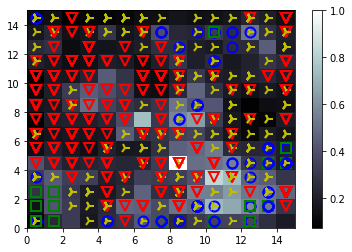

In [22]:
# Visualizing the results
labels3 = visualSom(x_train, y_train, som3)

In [23]:
propa3 = propabilitySom(labels3)

In [24]:
propa3.shape

(4, 15, 15)

In [25]:
p_vectors3 = som3.weights

In [26]:
p_vectors3.shape

(15, 15, 6)

In [27]:
taggings3 = taggingSom(labels3)

In [28]:
taggings3.shape

(15, 15)

In [29]:
predicted_y3 = [predict(instance, p_vectors3, taggings3, labels3) for instance in x_test]

from sklearn.metrics import classification_report

print (classification_report(y_test, predicted_y3, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.93      0.93      0.93       229
          1       0.87      0.62      0.72        63
          2       0.26      0.27      0.27        33
          3       0.77      0.85      0.81       168

avg / total       0.82      0.82      0.82       493



In [30]:
ensemble = [np.asarray(predicted_y1), np.asarray(predicted_y2), np.asarray(predicted_y3)]

In [31]:
predict = [np.bincount([ensemble[j][i] for j in range(3)]).argmax() for i in range(len(ensemble[1]))]

In [32]:
print (classification_report(y_test, predict, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.93      0.93      0.93       229
          1       0.82      0.87      0.85        63
          2       0.42      0.42      0.42        33
          3       0.84      0.82      0.83       168

avg / total       0.85      0.85      0.85       493



In [33]:
mapping = som.win_map(x_train)
mapping2 = som2.win_map(x_train)
mapping3 = som3.win_map(x_train)

In [34]:
result = np.array([])
for sample in x_test:
    pos1 = find_closest(sample, p_vectors, labels)
    pos2 = find_closest(sample, p_vectors2, labels2)
    pos3 = find_closest(sample, p_vectors3, labels3)
    l1 = len(mapping[pos1])
    l2 = len(mapping2[pos2])
    l3 = len(mapping3[pos3])
#     (pro1, pro2, pro3, pro4) = ((l1*propa[pos1]))
    pro1 = (l1*propa[0, pos1[0], pos1[1]] + l2*propa2[0, pos2[0], pos2[1]] + l3*propa3[0, pos3[0], pos3[1]])/(l1+l2+l3)
    pro2 = (l1*propa[1, pos1[0], pos1[1]] + l2*propa2[1, pos2[0], pos2[1]] + l3*propa3[1, pos3[0], pos3[1]])/(l1+l2+l3)
    pro3 = (l1*propa[2, pos1[0], pos1[1]] + l2*propa2[2, pos2[0], pos2[1]] + l3*propa3[2, pos3[0], pos3[1]])/(l1+l2+l3)
    pro4 = (l1*propa[3, pos1[0], pos1[1]] + l2*propa2[3, pos2[0], pos2[1]] + l3*propa3[3, pos3[0], pos3[1]])/(l1+l2+l3)
    tmp = np.argmax(np.array([pro1, pro2, pro3, pro4]))
    result = np.append(result, tmp)

In [35]:
from sklearn.metrics import classification_report

print (classification_report(y_test, result, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.95      0.93      0.94       229
          1       0.86      0.94      0.89        63
          2       0.51      0.55      0.53        33
          3       0.85      0.83      0.84       168

avg / total       0.87      0.87      0.87       493



In [36]:
data_new = pd.read_csv(r"../data/SD-3X_rocktype.csv")
x_new = data_new.iloc[:, 0:6].values
y_new = data_new.iloc[:, 6].values
y_new[y_new == 4] = 0
x_new = minmax.fit_transform(x_new)

In [37]:
result2 = np.array([])
l1 = len(mapping[pos1])
l2 = len(mapping2[pos2])
l3 = len(mapping3[pos3])
for sample in x_new:
    pos1 = find_closest(sample, p_vectors, labels)
    pos2 = find_closest(sample, p_vectors2, labels2)
    pos3 = find_closest(sample, p_vectors3, labels3)
#     (pro1, pro2, pro3, pro4) = ((l1*propa[pos1]))
    pro1 = (l1*propa[0, pos1[0], pos1[1]] + l2*propa2[0, pos2[0], pos2[1]] + l3*propa3[0, pos3[0], pos3[1]])/(l1+l2+l3)
    pro2 = (l1*propa[1, pos1[0], pos1[1]] + l2*propa2[1, pos2[0], pos2[1]] + l3*propa3[1, pos3[0], pos3[1]])/(l1+l2+l3)
    pro3 = (l1*propa[2, pos1[0], pos1[1]] + l2*propa2[2, pos2[0], pos2[1]] + l3*propa3[2, pos3[0], pos3[1]])/(l1+l2+l3)
    pro4 = (l1*propa[3, pos1[0], pos1[1]] + l2*propa2[3, pos2[0], pos2[1]] + l3*propa3[3, pos3[0], pos3[1]])/(l1+l2+l3)
    tmp = np.argmax(np.array([pro1, pro2, pro3, pro4]))
    result2 = np.append(result2, tmp)

In [38]:
from sklearn.metrics import classification_report

print (classification_report(y_new, result2, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.94      0.64      0.76       331
          1       0.98      0.92      0.95        95
          2       0.43      0.38      0.41        26
          3       0.58      0.91      0.71       205

avg / total       0.81      0.75      0.76       657

